## 1. Import Modeles

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 2. Load Data

In [ ]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, 
                          na_values='?', comment="\t",
                          sep=' ', skipinitialspace=True)
dataset = raw_dataset.copy()
dataset.tail()


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## 3. Data Preprocessing1

### 결측치 처리

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()

### 범주형 데이터 처리

In [ ]:
origin = dataset.pop('Origin')

dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### 데이터 분리

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=8)
test_dataset = dataset.drop(train_dataset.index)

## 4. Data Exploration

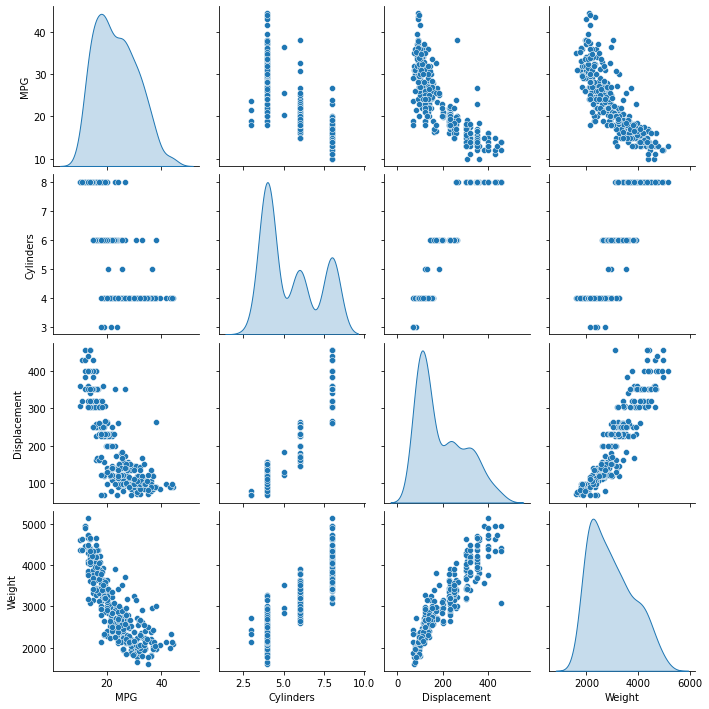

In [ ]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')  # target 변수 제외
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.455414,1.701227,3.0,4.000,4.0,8.000,8.0
Displacement,314.0,193.431529,103.757193,68.0,105.000,148.5,261.500,455.0
Horsepower,314.0,103.780255,37.757839,46.0,75.000,92.5,123.750,225.0
Weight,314.0,2974.668790,839.268622,1613.0,2245.250,2831.5,3571.250,5140.0
Acceleration,314.0,15.656369,2.796422,8.0,13.725,15.5,17.275,24.8
Model Year,314.0,76.025478,3.600584,70.0,73.000,76.0,79.000,82.0
USA,314.0,0.617834,0.486692,0.0,0.000,1.0,1.000,1.0
Europe,314.0,0.178344,0.383413,0.0,0.000,0.0,0.000,1.0
Japan,314.0,0.203822,0.403481,0.0,0.000,0.0,0.000,1.0


## 5. Data Preprocessing2

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalization

In [ ]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## 6. Network Structure

In [ ]:
def build_model():
    model = keras.models.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=[len(train_dataset.columns)]),
        keras.layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                  optimizer=optimizer,
                  metrics=['mae', 'mse'])
    return model

In [ ]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 잘 working 하는지 확인 : 임의의 10개의 데이터를 넣어서 출력해 봄
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result 

array([[-0.39416838],
       [-0.10216816],
       [-0.6559987 ],
       [-0.13518742],
       [-0.26623023],
       [-0.08870924],
       [-0.32703874],
       [-0.44912922],
       [-0.24083906],
       [-0.56254536]], dtype=float32)

## 7. Training

In [ ]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0 : print()
        print('.', end='')

EPOCHS = 1000
history = model.fit(
    normed_train_data, train_labels,
    epochs=EPOCHS, validation_split=0.2, verbose=0,
    callbacks=[PrintDot()]
)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,1.825463,0.879708,1.825463,5.358702,1.821895,5.358702,995
996,1.952785,0.941844,1.952785,4.846629,1.672513,4.846629,996
997,1.886114,0.899337,1.886114,5.686872,1.842122,5.686872,997
998,1.962296,0.914435,1.962296,4.784636,1.654661,4.784636,998
999,1.987154,0.930033,1.987154,5.069448,1.724085,5.069448,999


## 8. Visualization

In [ ]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(8, 12))

    plt.subplot(2, 1, 1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mae'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
            label='Validation Error')
    plt.ylim(0, 5)
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Squared Error [MPG]')
    plt.plot(hist['epoch'], hist['mse'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
             label='Validation Error')
    plt.ylim(0, 20)
    plt.legend()

    plt.show()

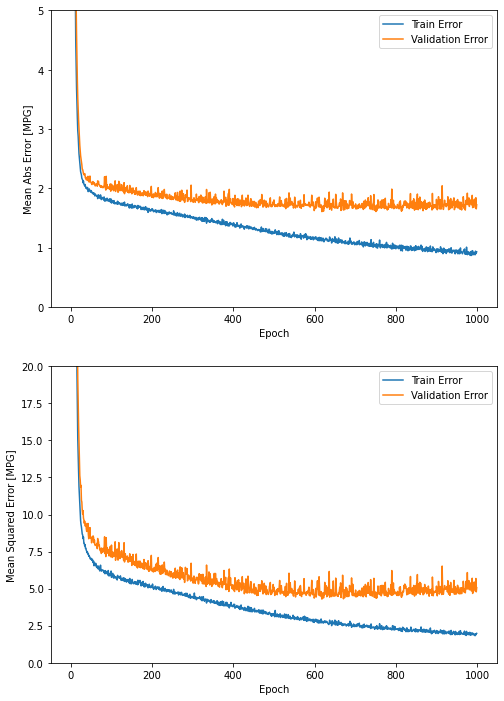

In [ ]:
plot_history(history)

## 9. Early Stopping


........................................................................

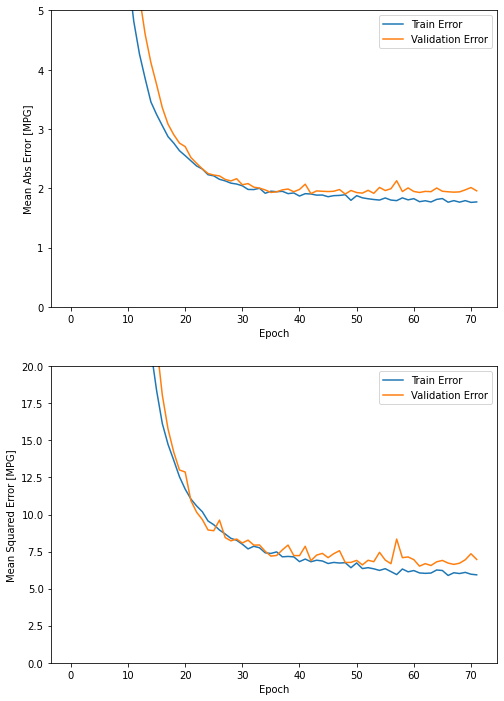

In [ ]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()])
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 8.4886 - mae: 2.1298 - mse: 8.4886
테스트 세트의 평균 절대 오차:  2.13 MPG


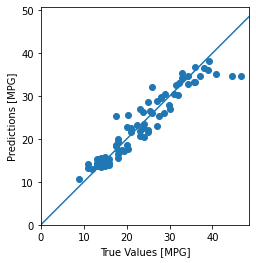

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
plt.axis('equal')
plt.axis('square')   # 정사각형 모양으로 plot
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])   # 직선을 그림(True Value = Predicted Vale)

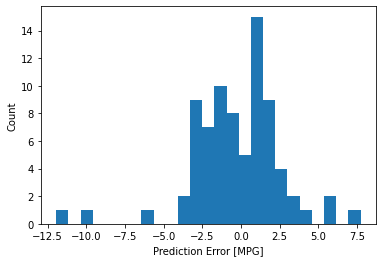

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")